## Overview

In this section, we will take a single Sentinel-2 L1C scene downloaded from the [Copernicus Browser](https://dataspace.copernicus.eu/) and learn how to read it using XArray, visualize it and compute spectral indices.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [6]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install rioxarray
  !pip install xarray-spatial


In [7]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import zipfile
import geopandas as gpd
import xrspatial.multispectral as ms


In [8]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [9]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

s2_scene = 'S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE.zip'
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/'

download(data_url + 's2/' + s2_scene)

aoi = 'bangalore.geojson'
download(data_url + aoi)


## Data Pre-Processing

We first unzip the zip archive and create a XArray Dataset from the individual band images.



In [10]:
s2_filepath = os.path.join(data_folder, s2_scene)

with zipfile.ZipFile(s2_filepath) as zf:
  zf.extractall(data_folder)

Sentinel-2 images come as individual JPEG2000 rasters for each band. The image files are located in the `GRANULE/{SCENE_ID}/IMG_DATA/` subfolder. We find the files and read them using `rioxarray`.

In [11]:
import glob
s2_folder = s2_filepath[:-4]

band_files = {}

for filepath in glob.glob(os.path.join(s2_folder, 'GRANULE', '*', 'IMG_DATA', '*B*.jp2')):
  filename = os.path.basename(filepath)
  # Extract the part of the filename containing band name such as 'B01'
  band_name = os.path.splitext(filename)[0].split('_')[-1]
  band_files[band_name] = filepath

band_files

{'B01': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B01.jp2',
 'B06': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B06.jp2',
 'B07': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B07.jp2',
 'B05': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B05.jp2',
 'B03': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B03.jp2',
 'B08': 'data/S2A_MSIL1C_20230212T050931_N0509_R019_T43PGQ_20230212T065641.SAFE/GRANULE/L1C_T43PGQ_A039913_20230212T051514/IMG_DATA/T43PGQ_20230212T050931_B08.jp2',
 'B11': 'd

Different Sentinel-2 bands have different spatial resolutions. To put them in the same array, their dimensions must match. So we combine bands of similar resolutions and resample others to match them.

* B04, B03, B02 and B08 = 10m
* B12, B11, B07, B06, B05 and B08A = 20m
* B10, B09, B1 = 60m

In [12]:
b4 = rxr.open_rasterio(band_files['B04'], chunks=True)
b3 = rxr.open_rasterio(band_files['B03'], chunks=True)
b2 = rxr.open_rasterio(band_files['B02'], chunks=True)
b8 = rxr.open_rasterio(band_files['B08'], chunks=True)

stack1 = xr.concat([b4, b3, b2, b8], dim='band').assign_coords(band=['B04', 'B03', 'B02', 'B08'])
stack1

<xarray.DataArray (band: 4, y: 10980, x: 10980)>
dask.array<concatenate, shape=(4, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [13]:
b5 = rxr.open_rasterio(band_files['B05'], chunks=True)
b6 = rxr.open_rasterio(band_files['B07'], chunks=True)
b7= rxr.open_rasterio(band_files['B07'], chunks=True)
b8a = rxr.open_rasterio(band_files['B8A'], chunks=True)
b11 = rxr.open_rasterio(band_files['B11'], chunks=True)
b12 = rxr.open_rasterio(band_files['B12'], chunks=True)

stack2 = xr.concat([b5, b6, b7, b8a, b11, b12], dim='band').assign_coords(
    band=['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'])
stack2 = stack2.rio.reproject_match(stack1)

In [14]:
scene = xr.concat([stack1, stack2], dim='band')
scene = scene.where(scene != 0)
scene

<xarray.DataArray (band: 10, y: 10980, x: 10980)>
dask.array<where, shape=(10, 10980, 10980), dtype=float32, chunksize=(6, 3344, 3344), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B08' ... 'B07' 'B8A' 'B11' 'B12'
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

We will clip the scene to the geometry of the GeoJson file. We must ensure that the projection of the GeoDataFrame and the XArray DataArray match.

In [17]:
aoi_path = os.path.join(data_folder, aoi)
aoi_gdf = gpd.read_file(aoi_path)
geometry = aoi_gdf.to_crs(scene.rio.crs).geometry
clipped = scene.rio.clip(geometry)
clipped

<xarray.DataArray (band: 10, y: 3426, x: 3510)>
dask.array<getitem, shape=(10, 3426, 3510), dtype=float32, chunksize=(6, 2133, 1840), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B08' ... 'B07' 'B8A' 'B11' 'B12'
  * x            (x) float64 7.67e+05 7.67e+05 7.67e+05 ... 8.02e+05 8.02e+05
  * y            (y) float64 1.454e+06 1.454e+06 1.454e+06 ... 1.42e+06 1.42e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Sentinel-2 pixel values need to be converted to reflectances using the following formula:

`ρ   =  (L1C_DN + RADIO_ADD_OFFSET) / QUANTIFICATION_VALUE`

`QUANTIFICATION_VALUE` for all S2 scenes is **10000** and starting from January 22,2023, all new scenes have a `RADIO_ADD_OFFSET` of **-1000**



In [18]:
scaled = (clipped - 1000)/10000

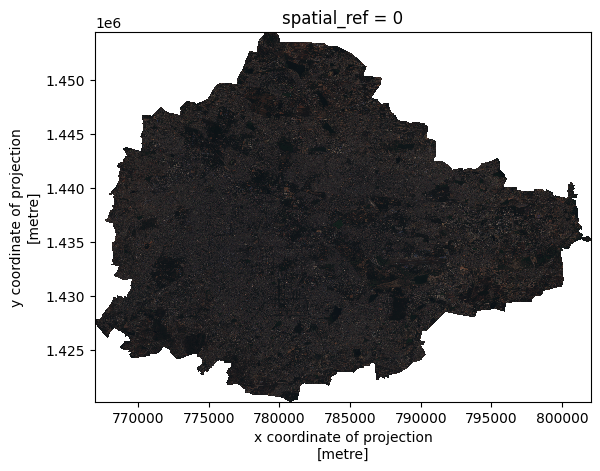

In [19]:
scaled.sel(band=['B04', 'B03', 'B02']).plot.imshow()

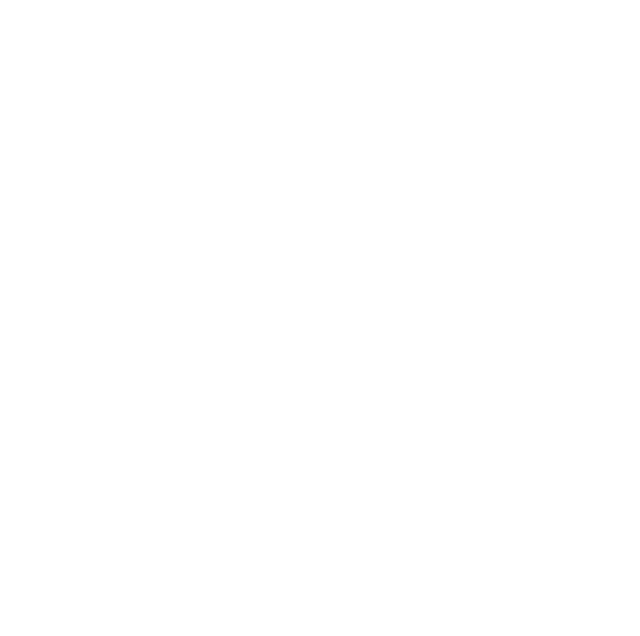

In [20]:
image = ms.true_color(*scaled.sel(band=['B04', 'B03', 'B02']))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
image.plot.imshow(ax=ax)
ax.set_axis_off()
plt.show()